<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Stochastic Gradient Descent (SGD)</font></p>

<p style="font-family:Times;font-size:200%; text-align:center"> <font color='red'>Dengan ADAM</font></p>

___



# Tugas 2 DL2021
## M.Naufal Irham R. (108181019)

Code di bawah ini tidak banyak diubah agar memudahkan dalam mengkoreksi. Hanya beberapa baris saja yang diubah untuk kebutuhan modifikasi optimizer menjadi optimizer ADAM

In [1]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:5.4f}'.format})

#Sigmoid function & its derivative
sigmoid = lambda Z: 1/(1+exp(-Z))
dsigmoid = lambda A: A*(1-A)

#ReLU function & its derivative
ReLU  = lambda Z: Z.clip(0)
#Derivative of ReLU function
dReLU = lambda A: (A > 0)*1

#Derivativer of tanh()
dtanh = lambda A: 1-A**2

#Derivative oh arctanh
darctanh = lambda A: 1/(A**2+1)

#Softplus function & its derivative
splus = lambda Z: log(1+exp(Z))
dsplus = lambda A: 1/(1+exp(-A))

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))   
    return xt

In [2]:
class NeuralNetwork:
    
    def __init__(self,x,y,hlayers,alpha,mbs): # ada h nodes di dalam hidden layer  hlayers = [7, 3, 34, 89]
        self.X  = x   #input
        self.y  = y   #output
        self.hlayers = hlayers   #note: untuk model Perceptron gunakan hlayers = []
        self.α  = alpha
        self.mbs = mbs
        
        #self.Xt = x   #akan digunakan untuk SGD
        #self.yt = y   #akan digunakisn di SGD
        
        assert ndim(y)            == 2     #y harus berupa matriks (berdimensi 2)
        assert type(self.hlayers) == list  #hlayers harus berupa sebuah list
        
        self.N, ni = shape(x)   #jumlah features (variables)
        self.N, no = shape(y)   #jumlah observasi (self.N) dan jumlah output (no)
        
        self.neurons = [ni]
        self.neurons.extend(self.hlayers)
        self.neurons.append(no)   #jumlah neurons per layer, termasuk input layer 
        self.nlayers  = len(self.neurons)-1  #number of layers (tidak termasuk input layer)

        "Initial values untuk parameter w and b"

        self.w, self.b = [], []
        for i in arange(self.nlayers):
            self.w.append(randn(self.neurons[i], self.neurons[i+1]))  #Sinapsis dari layer ke i menuju layer ke (i+1)  
            self.b.append(randn(1, self.neurons[i+1]))           #Bias di layer ke (i+1)    
        
        ###Modifikasi ada dibawah ini#################################
        self.Vw, self.Vb = [], []
        for i in arange(self.nlayers):
            self.Vw.append(zeros((self.neurons[i], self.neurons[i+1])))  
            self.Vb.append(zeros((1, self.neurons[i+1])))  

        self.Mw, self.Mb = [], []
        for i in arange(self.nlayers):
            self.Mw.append(zeros((self.neurons[i], self.neurons[i+1])))  
            self.Mb.append(zeros((1, self.neurons[i+1])))  
        #############################################################

    def training(self):
        acak  = choice(len(self.y), int(self.mbs*len(self.y)), replace = False)   #bikin indeks pengambilan secara acak sebesar bs
        Xmini = self.X[acak]   #mini batch sample dari X
        ymini = self.y[acak]   #mini batch sample dari y

        t = 1 #Waktu

        for Xt,yt in zip(Xmini,ymini):
        
            "Forward propagation (perambatan maju)"
    
            Z, A = [], [Xt]
        
            "Dimulai dari Hidden layers"
            for j in arange(len(hlayers)):   #hanya hidden layers
                Z.append(linear(A[j],self.w[j],self.b[j]))  #Reaksi kimia di layer ke (j + 1)
                A.append(tanh(Z[j]))     #Aliran listrik di layer ke (j + 1)
        
            "Output layer"
            Z.append(linear(A[self.nlayers-1],self.w[self.nlayers-1],self.b[self.nlayers-1]))  #Reaksi kimia di output layer
            A.append(sigmoid(Z[self.nlayers-1]))
            
            self.predicted_yt = A[self.nlayers]
            e         = yt-self.predicted_yt
            self.z = Z
            self.a = A
            
            "Backward propagation (perambatan mundur)"
        
            
            "Dimulai dari output layer"
            dCdZ = [(-2*e/len(yt))*dsigmoid(A[::-1][0])]  #berbentuk list agar bisa di-append, mulai dari output layer

            "Hidden layer"                                           
            for m in arange(self.nlayers-1):  #dan mundur ke layer berikutnya, sampai hidden layer pertama
                dCdZ.append((dCdZ[m]@(self.w[::-1][m]).T)*dtanh(A[::-1][m+1]))   #delta
            

            ### Modidikasi ada dibawah ini ########################## 
            "Perubahan parameters (w dan b):"
            one  = ones([1,len(yt)])
            
            beta1   = 0.9
            beta2   = 0.999
            epsilon = 10**(-8) 

            for n in arange(self.nlayers):
                
                "Algoritma ADAM"               
                self.gw = A[n].T@dCdZ[::-1][n] #Dapatkan gradients untuk w dari dCdZ 

                self.Mw[n] = beta1*array(self.Mw[n]) + (1-beta1)*self.gw
                self.Vw[n] = beta2*array(self.Vw[n]) + (1-beta2)*(self.gw)**2
                
                MwHat = self.Mw[n]/(1-(beta1)**t)
                VwHat = self.Vw[n]/(1-(beta2)**t)

                self.w[n] -= self.α*MwHat/(sqrt(VwHat) + epsilon) #Update parameter w
              
                self.gb = one@dCdZ[::-1][n] #Dapatkan gradients untuk b dari dCdZ    

                self.Mb[n] = beta1*array(self.Mb[n]) + (1-beta1)*self.gb
                self.Vb[n] = beta2*array(self.Vb[n]) + (1-beta2)*(self.gb)**2
                
                MbHat = self.Mb[n]/(1-(beta1)**t)
                VbHat = self.Vb[n]/(1-(beta2)**t)
                
                self.b[n] -= self.α*MbHat/(sqrt(VbHat) + epsilon) #Update parameter b


            t += 1
            ###############################################################

    def prediction(self, Xs, ys):   #Gunakan data secara keseluruhan
        
        "Forward propagation (perambatan maju)"
    
        Z, A = [], [Xs]
        
        "Dimulai dari Hidden layers"
        for j in arange(len(hlayers)):   #hanya hidden layers
            Z.append(linear(A[j],self.w[j],self.b[j]))  #Reaksi kimia di layer ke (j + 1)
            A.append(tanh(Z[j]))     #Aliran listrik di layer ke (j + 1)
        
        "Output layer"
        Z.append(linear(A[self.nlayers-1],self.w[self.nlayers-1],self.b[self.nlayers-1]))  #Reaksi kimia di output layer
        A.append(sigmoid(Z[self.nlayers-1]))
    
        self.predicted_y = A[self.nlayers]
        e         = ys-self.predicted_y
        self.Cost = e.T@e/len(ys)  #mean squared error

Sampai epoch ke 25 dicapai akurasi MSE sebesar 0.0010420 dengan waktu 0:00:02.117113
Sampai epoch ke 50 dicapai akurasi MSE sebesar 0.0023439 dengan waktu 0:00:04.165130
Sampai epoch ke 75 dicapai akurasi MSE sebesar 0.0007611 dengan waktu 0:00:06.244216
Sampai epoch ke 100 dicapai akurasi MSE sebesar 0.0027724 dengan waktu 0:00:08.252598
Sampai epoch ke 125 dicapai akurasi MSE sebesar 0.0008590 dengan waktu 0:00:09.954150
Sampai epoch ke 150 dicapai akurasi MSE sebesar 0.0007472 dengan waktu 0:00:11.076994
Sampai epoch ke 175 dicapai akurasi MSE sebesar 0.0007912 dengan waktu 0:00:12.139892
Sampai epoch ke 200 dicapai akurasi MSE sebesar 0.0010057 dengan waktu 0:00:13.307916
Sampai epoch ke 225 dicapai akurasi MSE sebesar 0.0012393 dengan waktu 0:00:14.371576
Sampai epoch ke 250 dicapai akurasi MSE sebesar 0.0008272 dengan waktu 0:00:15.442282

Akurasi dengan data training: 0.0008272 



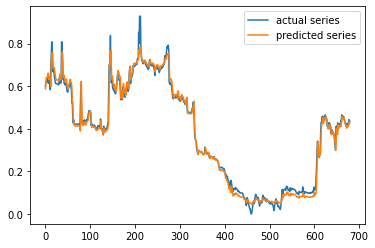

Waktu yang diperlukan dari mulai training (250 epochs):  0:00:16.522066


In [3]:
A  = pd.read_csv('D:/Downloadables/Data/INAF.JK.csv')  #Data time series harian harga saham Bank Mandiri sejak 02 Januari 2015
A6 = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6[:,newaxis]  #berupa matriks
                                     
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)

ts = 1  #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xt = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel y

x = xt[-800:,:]    #Ambil 800 observasi terakhir

#Data untuk training
Xtrain = x[0:680, :-1]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :-1]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:]   #ambil kolom terakhir

hlayers = [3, 2]  #Dua hidden layers, masing-masing dengan 3 neurons dan 2 neurons
alpha   = 0.05
mbs     = 0.15  #hanya 15% dari seluruh observasi yang digunakan untuk penaksiran parameter
epochs  = 250
#Rangkuman activation function di hidden layers & output layer

#tanh & sigmoid:
#SGD dengan Momentum: mbs = 0.15, alpha = 0.65, beta = 0.1, epochs = 400 initial values di luar epochs
#SGD : mbs = 1,    alpha = 0.17,  epochs = 70, 
#MBGD: mbs = 0.15, alpha = 0.165, epochs = 400, alpha = 0.27, epochs = 1600
#      mbs = 0.20, alpha = 0.165, epochs = 450

tic = datetime.now()

seed(20200219)

ann2 = NeuralNetwork(Xtrain,ytrain,hlayers,alpha,mbs)   #pembuatan object ann2

for t in range(epochs): 
    ann2.training()
    ann2.prediction(Xtrain,ytrain)   #Gunakan data untuk training secara keseluruhan
    
    if (t+1)%(epochs/10) == 0:   #tampilkan output lima kali
        print("Sampai epoch ke", t+1,"dicapai akurasi MSE sebesar %8.7f" %ann2.Cost,"dengan waktu", datetime.now()-tic)

toc = datetime.now()
print('\nAkurasi dengan data training: %8.7f' %ann2.Cost,'\n')

plt.plot(ytrain, label = 'actual series')
plt.plot(ann2.predicted_y, label = 'predicted series')
plt.legend()
plt.show()

toc = datetime.now()
print(f'Waktu yang diperlukan dari mulai training ({epochs} epochs): ', toc-tic)

#### Test model Deep Learning dengan data di periode yang lain


MSE training: 0.0008272 
MSE testing : 0.0025428


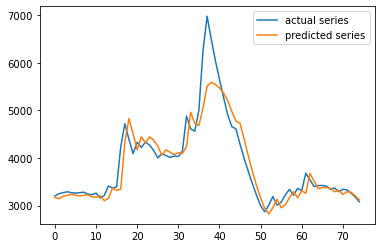

Waktu untuk training (dengan 250 epochs) dan prediksi:  0:00:17.280198


In [4]:
#Parameters w0, w1 dan w2 sebagai ilmu pengetahuan atau knowledge yang diperoleh selama training 
#akan digunakan disini untuk di-test kemampuannya memprediksi. 
#Data yang dipakai Xtest dan ytest yang tidak digunakan selama training.

Cost_train = ann2.Cost    #Ini untuk data untuk training

ann2.prediction(Xtest,ytest)   #Gunakan data untuk test
predicted_ytest = ann2.predicted_y
Cost_test = ann2.Cost          #Ini dengan data untuk test 

print('\nMSE training: %8.7f'%Cost_train,'\nMSE testing : %8.7f'%Cost_test)

ytesto    = ytest*(Bmax-Bmin)+Bmin      #Kembalikan datanya ke original unit dalam satuan dolar
ytesthato = predicted_ytest*(Bmax-Bmin)+Bmin   #Kembalikan datanya ke original unit dalam satuan dolar

plt.plot(ytesto, label = 'actual series')
plt.plot(ytesthato, label = 'predicted series')
plt.legend()
plt.show()
toc = datetime.now()

print(f'Waktu untuk training (dengan {epochs} epochs) dan prediksi: ',  toc-tic)

In [5]:
"Proses penyimpanan model:"

#Parameters w dan b dijadikan satu list dalam params
params = [ann2.w, ann2.b]

#Simpan params di dalam IntelModel.dat di komputer
pickle.dump(params, open("MandiriModel.dat", "wb"))  #Penyimpanan model parameters, wb: write binary data

#Diasumsikan sudah ada tambahan data baru Xtest maka langkah prediksi harga saham mirip seperti 
#yang dilakukan di atas. Tambahan data baru bisa pula berasal dari hasil prediksi sebelumnya 
#bila mau dilakukan prediksi yang iteratif.

#Caranya, panggil lagi paramaters dari model Deep Learning:

#### Pemanggilan dan penggunaan Model Deep Learning oleh pihak lain
>Model Deep Learning akan dipanggil dan digunakan untuk forecasting


MSE training: 0.0008272 
MSE testing : 0.0025428


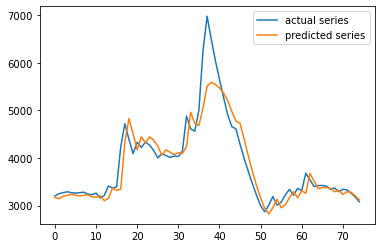

In [6]:
"Proses pemanggilan model"
pars = pickle.load(open("MandiriModel.dat", "rb"))  #rb: read binary data
w = pars[0]
b = pars[1]
nlayers = len(w)

"Forward propagation (perambatan maju)"
    
Z, A = [], [Xtest]
        
"Dimulai dari Hidden layers"
for j in arange(len(hlayers)):   #hanya hidden layers
    Z.append(linear(A[j],w[j],b[j]))  #Reaksi kimia di layer ke (j + 1)
    A.append(tanh(Z[j]))     #Aliran listrik di layer ke (j + 1)
        
"Output layer"
Z.append(linear(A[nlayers-1],w[nlayers-1],b[nlayers-1]))  #Reaksi kimia di output layer
A.append(sigmoid(Z[nlayers-1]))
    
predicted_ytest = A[nlayers]
e         = ytest-predicted_ytest
Cost_test = e.T@e/len(ytest)  #mean squared error

#ann2.prediction(Xtest,ytest)   #Gunakan data untuk test
#ytesthat = ann2.predicted_y
#Cost_test = ann2.Cost          #Ini dengan data untuk test 

print('')
print('MSE training: %8.7f'%Cost_train,'\nMSE testing : %7.7f'%Cost_test)

"Kembalikan datanya ke original unit dalam satuan dolar"
ytesto = ytest*(Bmax-Bmin)+Bmin       
ytesthato = predicted_ytest*(Bmax-Bmin)+Bmin 

plt.plot(ytesto, label = 'actual series')
plt.plot(ytesthato, label = 'predicted series')
plt.legend()
plt.show()